In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
data = pd.read_csv('/content/data3.csv')
data.head()

,nama,klasifikasi
0,3 ayam mie telor super kuning,0
1,3 ayam mie telor super merah,0
2,5 days croissant cheese,0
3,7 cereal bar cocoa chia,0
4,7 cereal bar yoghurt berry,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9532 entries, 0 to 9531
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nama         9532 non-null   object
 1   klasifikasi  9532 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

X = data['nama'].apply(lambda text: stemSentence(text))
X.head()

0     3 ayam mie telor super kune
1    3 ayam mie telor super merah
2           5 day croissant chees
3         7 cereal bar cocoa chia
4      7 cereal bar yoghurt berri
Name: nama, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder_Y = LabelEncoder()
y = labelencoder_Y.fit_transform(data.iloc[:,1].values)
print(y)

[0 0 0 ... 8 8 8]


In [ ]:
#Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

max_sequence_length = 25
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
X = padded_sequences

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
type(X_train)
type(X_test)

numpy.ndarray

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras import layers
from keras.layers import Flatten
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(LSTM(50))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            341300    
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 9)                 459       
                                                                 
Total params: 361,959
Trainable params: 361,959
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizers.Adam(lr=0.01),
            metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='min')

In [ ]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20,batch_size=30, callbacks=([callbacks]))

Epoch 1/20
286/286 [==============================] - 10s 26ms/step - loss: 0.5207 - accuracy: 0.8276 - val_loss: 0.2247 - val_accuracy: 0.9329
Epoch 2/20
286/286 [==============================] - 6s 21ms/step - loss: 0.0923 - accuracy: 0.9725 - val_loss: 0.1846 - val_accuracy: 0.9403


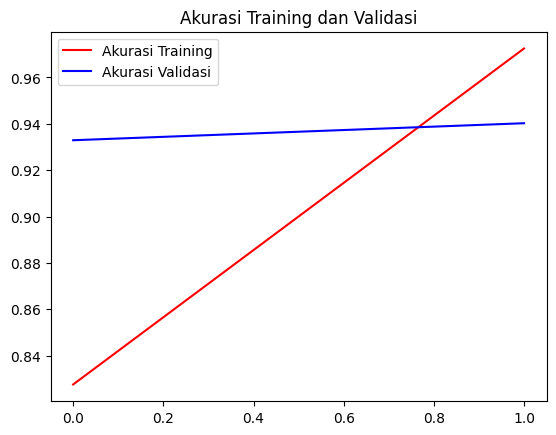

<Figure size 640x480 with 0 Axes>

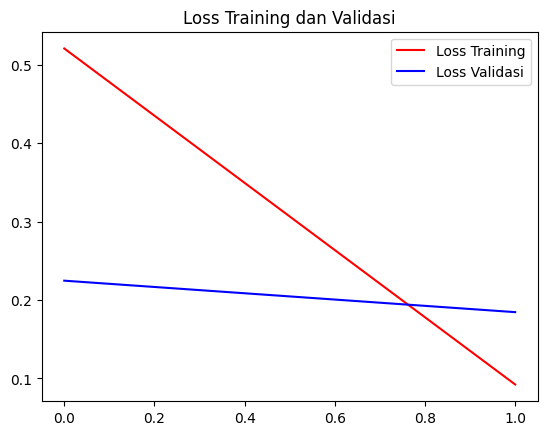

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Training')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
plt.title('Akurasi Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
plt.title('Loss Training dan Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
#testing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

text = input(stemSentence(""))
text = tokenizer.texts_to_sequences([text])
padded_input_sequence = pad_sequences(text, maxlen=max_sequence_length)
predictions = model.predict(padded_input_sequence)
predicted_class = predictions.argmax(axis=-1)[0]

prediksi = labelencoder_Y.inverse_transform([predicted_class])
label = ['Belanja', 'Makanan & Minuman', 'Kesehatan & Kecantikan', 'Pendidikan', 'Transportasi', 'Pinjaman & Tagihan', 'Sosial', 'Hiburan', 'Investasi']
print("Barang masuk ke dalam kategori: ", label[predicted_class])


kredit
1/1 [==============================] - 0s 23ms/step
Barang masuk ke dalam kategori:  Pinjaman & Tagihan


In [ ]:
# !mkdir -p saved_model
model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')

# # Check its architecture
# new_model.summary()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


30/30 - 0s - loss: 0.2480 - accuracy: 0.9361 - 144ms/epoch - 5ms/step
Restored model, accuracy: 93.61%


In [ ]:
model.save('my_model.h5')

In [ ]:
# buat load model
new_model = tf.keras.models.load_model('/content/my_model.h5')
new_model.summary()
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            359150    
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 9)                 459       
                                                                 
Total params: 379,809
Trainable params: 379,809
Non-trainable params: 0
_________________________________________________________________
30/30 - 1s - loss: 0.2480 - accuracy: 0.9361 - 724ms/epoch - 24ms/step
Restored model, accuracy: 93.61%
